**Transfer Learning**


---



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
image_size = 784
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

# image transform
transform1 = transforms.Compose([transforms.Resize(64),
                                 transforms.Grayscale(3), #return 3 channels 
                                 transforms.ToTensor()])

# download train dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=True,
                                           transform=transform1,
                                           download=True)

# download test dataset
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=False,
                                           transform=transform1,
                                           download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader =  torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)



In [6]:
# Define a function to train the model for one epoch
def train_model(model, optimizer, loss_function, train_loader):
  
  # Put model in train mode
  model.train()

  # For loss calculation
  total_loss = 0
  total_correct = 0
  dataset_size = len(train_loader.dataset)

  # Go over each batch
  for X, y in train_loader:
    X = X.to(device)
    y = y.to(device)

    y_pred = model(X)

    loss = loss_function(y_pred,y)  
    # In the above
    #   input:y_pred is logits, target y is integer index.
    #   target could also be a vector of probabilities
    #     in that case, y.softmax(1) could be used to convert to probabilities  
    
    # Zero the gradients, backpropagate the gradients, update the parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate loss
    total_loss += loss_function(y_pred, y).item()
    total_correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

  print(f"Training Loss:{total_loss/dataset_size:0.4f}, \
          Training Accuracy:{total_correct/dataset_size:0.4f}")


# Define a function to test the model
def test_model(model, loss_function, test_loader):
  # Put the model into evaluation mode
  model.eval()

  # For loss calculation
  total_loss = 0
  total_correct = 0
  dataset_size = len(test_loader.dataset)

  # Do not calculate gradients
  with torch.no_grad():
    for X,y in test_loader:
      X = X.to(device)
      y = y.to(device)

      y_pred = model(X)

      # Calculate loss
      total_loss += loss_function(y_pred, y).item()
      total_correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
  
  print(f"Test Loss: {total_loss/dataset_size:0.4f}, \
          Test Accuracy: {total_correct/dataset_size:0.4f}")

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
torch.Size([3, 64, 64])
5


Text(0.5, 1.0, '8')

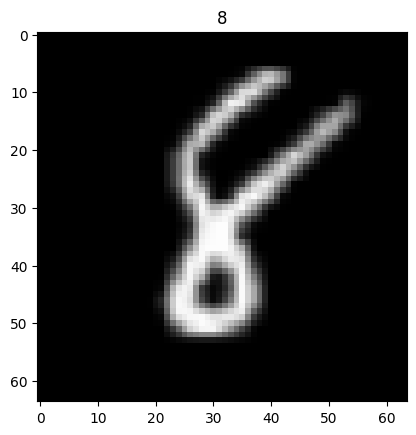

In [7]:
# Check out images in the dataset
print(train_dataset)
#print(train_dataset[0]) # is a tuple of (data,target)
print(train_dataset[0][0].shape)  # image (a tensor)
print(train_dataset[0][1])        # label (an integer)


#print(train_dataset.data.shape)   # all images in the dataset

# Look at a sample
idx = 0
image0 = train_dataset.data[idx]
label0 = train_dataset.targets[idx]

# The above image0 is of size [28,28], not yet transformed
# Dataloader will do the transform and output it in batches
image, label = next(iter(train_loader))
# The image is of size [128,3,64,64]

# To display a single image
image1 = image[0].squeeze()     # get the 0th image in batch
image1 = image1.permute(1,2,0)  # channel goes to the end
image1 = image1.numpy()         # from tensor to numpy
label1 = label[0].item()

plt.imshow(image1)
plt.title(label1)


Download a model 

In [8]:
model1 = torchvision.models.vgg19(pretrained=True).to(device)
print(model1)

!pip install torchinfo
from torchinfo import summary
summary(model1, (1, 3, 32,32), col_names=["kernel_size", "output_size", "num_params"])



/home/bahadir/miniconda3/envs/vesuvius/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bahadir/miniconda3/envs/vesuvius/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/bahadir/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [04:16<00:00, 2.24MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

/home/bahadir/miniconda3/envs/vesuvius/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/bahadir/miniconda3/envs/vesuvius/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
VGG                                      --                        [1, 1000]                 --
├─Sequential: 1-1                        --                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         --                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [3, 3]                    [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         --                        [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    2                         [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [3, 3]                    [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         --                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-8      

In [9]:
# You can access the modules/layers inside model
#print(model1)
#print(model1.features)
#print(model1.avgpool)
print(model1.classifier)
print(model1.classifier[0])
print(model1.classifier.parameters)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Linear(in_features=25088, out_features=4096, bias=True)
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)>


In [10]:
# Get another copy of the model and play with it
model2 = torchvision.models.vgg19(pretrained=True).to(device)

# Freeze the parameters in the features part
for param in model2.features.parameters():
  param.requires_grad = False

# Create an identity network; you can replace a part of the network
#class identity_block(torch.nn.Module):
#  def __init__(self):
#    super().__init__()
#  def forward(self,x):
#    return x
# For example, 
#model2.avgpool = identity_block()
# OR
#model2.avgpool = torch.nn.Identity()

# Replace the last layer of the classifier to have 5 out_features
#model2.classifier[6] = nn.Linear(in_features=4096,out_features=5)
#print(model2)

# Create a new classifier block
class new_block(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=25088, out_features=100)
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Linear(in_features=100,out_features=5)
  
  def forward(self,x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    x = self.linear2(x)
    # x = self.dropout1(x) # Adding this would not change print(model) but
    #   the forward process would change
    #   Note that when you print(model), it does not show flattening...
    return x

# Replace the existing block
model2.classifier = new_block()
# OR 
'''
model2.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=100,out_features=5))
'''

print(model2)

# Access a specific layer
#print(model2.classifier.linear1)
# OR
#print(model2.classifier[0])

 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
# Take part of a model
#   Create a list and unpack it (with *) for nn.Sequential
model_part = nn.Sequential(*[model2.features[i] for i in range(31)])
print(model_part)

# Check out the weights; they should be equal
for param in model2.features[0].parameters():
  print(param.data[0])
  print(param.requires_grad)
  

for param in model_part[0].parameters():
  print(param.data[0])
  print(param.requires_grad)
  

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
# Now, pass a random input, check out the dimension of the model_part
#image, label = next(iter(train_loader))
image = torch.randn((1,3,64,64)).to(device)
y = model_part(image)
print(y.shape)
#>> torch.Size([1, 512, 4, 4])

# Using shape info, you can create a new block and append to model_part
model_part2 = nn.Sequential(
    nn.Flatten(),   
    # The above is part of nn.module. Compare with nn.flatten()
    # ... If a class is written, in .forward, you can write x.view(-1,512*4*4)
    # For vgg19, print(model) doesn't display .forward but the defined layers
    nn.Linear(in_features=512*4*4, out_features=100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=100,out_features=10))

#print(model_part2)

# Append these blocks
model3 = nn.Sequential(model_part,model_part2).to(device)
print(model3)
#print(model3[0][0])

y2 = model3(image)
print(y2.shape)


torch.Size([1, 512, 4, 4])
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=

In [13]:
# Let's train
loss_function = torch.nn.CrossEntropyLoss()     
optimizer = torch.optim.SGD(model3.parameters(),lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
  print('Epoch:',epoch)
  # Train loss
  train_model(model3, optimizer, loss_function, train_loader)

  # Test loss
  test_model(model3, loss_function, test_loader)

Epoch: 0
Training Loss:0.0060,           Training Accuracy:0.7781
Test Loss: 0.0019,           Test Accuracy: 0.9507
Epoch: 1
Training Loss:0.0027,           Training Accuracy:0.9087
Test Loss: 0.0012,           Test Accuracy: 0.9638
Epoch: 2


KeyboardInterrupt: 